In [1]:

import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import jax
import jax.scipy.special as sci
import jax.scipy.integrate as integrate
import jax.numpy as jnp
from jax import grad
import numpy as np
import sys


filename = "./jax_adjoint.conf"


import MaNTA
import toml

Config = toml.load( filename )

conf = Config.get("configuration")
if conf == None:
    print("Missing [configuration] section in " + filename)
    sys.exit(1)

import importlib.util

if "PythonModuleName" in conf:
    mod_name = conf["PythonModuleName"]
    if "PythonModuleFile" in conf:
        mod_path = conf["PythonModuleFile"]
    else:
        print("Must specify a file containing a python module if you specify a python module to use")
        sys.exit(1)
    mod_spec = importlib.util.spec_from_file_location( mod_name, mod_path )
    module_handle = importlib.util.module_from_spec( mod_spec )
    sys.modules[ mod_name ] = module_handle
    try:
        mod_spec.loader.exec_module(module_handle)
    except Exception:
        # If execution fails, remove the module from sys.modules
        del sys.modules[mod_name]
        raise

    print(f"Using python module {mod_name} from file {mod_path}\n")

    module_handle.registerTransportSystems()


Using python module JAXNonlinearDiffusion from file /home/eatocco/projects/MaNTA/python/JAXTransportSystem.py



In [2]:


data = Dataset("./jax_adjoint.nc")
print(data)
Vars = data.groups
Grid = jnp.array(np.array(data.groups["Grid"].variables["CellBoundaries"]))
t = jnp.array(np.array(data.variables["t"]))
x = jnp.array(np.array(data.variables["x"]))
u = jnp.array(np.array(Vars["Var0"].variables["u"]))
data.close()

/tmp/ipykernel_63023/2012078402.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Grid = jnp.array(np.array(data.groups["Grid"].variables["CellBoundaries"]))


<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): t(21), x(301)
    variables(dimensions): float64 t(t), float64 x(x), float64 nVariables(), float64 GFn(), float64 np(), float64 np_boundary()
    groups: Grid, Var0, G_p, G_boundary


/tmp/ipykernel_63023/2012078402.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  t = jnp.array(np.array(data.variables["t"]))
/tmp/ipykernel_63023/2012078402.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = jnp.array(np.array(data.variables["x"]))
/tmp/ipykernel_63023/2012078402.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more

In [3]:

# q = jnp.array(np.array(Vars["Var0"].variables["q"]))

# G0 = np.array(data.variables["G0"])
# print(G0)
# p0 = np.array(data.variables["p0"])
# print(p0)

# data.close()


In [4]:
u0 = 0.3#u[0,:]

T_s = 50
D = 2.0
c= 0.3

# d = np.sqrt(c)


# S = d*np.sqrt(np.pi)*( d/np.sqrt(np.pi)*( np.exp(-(x-b)**2/c) - np.exp(-(1-b)**2/c) ) + (1 - b)*sci.erf((1-b)/d)
#                      + (1-x)*sci.erf(b/d) - (x-b)*sci.erf((x-b)/d) )

# uan = (u0**(1+a) + T_s/D*(1+a)*S)**(1/(1+a))
def uan(x,c,a,u1):
    b = 0.02
    d = 50.0

    exponent = 0.0

    y = (x - c)/jnp.sqrt(b)
    G = (b*d/(4*a)) * ( jnp.exp( -(1-c)**2/b ) - jnp.exp( -y**2 ) ) + (d*jnp.sqrt( b*jnp.pi )/(4*a)) * ( (c-1)*sci.erf( (c-1)/jnp.sqrt(b) ) + (1-x)*sci.erf(c/jnp.sqrt(b)) - (x-c)*sci.erf(y) )
    u2 = u1**(1+exponent) + 2*(1+exponent)*G
    return u2**(1.0/(1+exponent))

g = lambda c, D, u0 : integrate.trapezoid(0.5*uan(x,c,D, u0)**2,x)

gradp = jax.grad(g, argnums=(0,1,2))
grad_c, grad_kappa, grad_u0 = gradp(c, D, u0)



$\frac{\partial u}{\partial t} - \kappa \frac{\partial^2 u}{\partial x^2} = A \exp{(-(x-c)^2/b)}$

/tmp/ipykernel_63023/4281011695.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


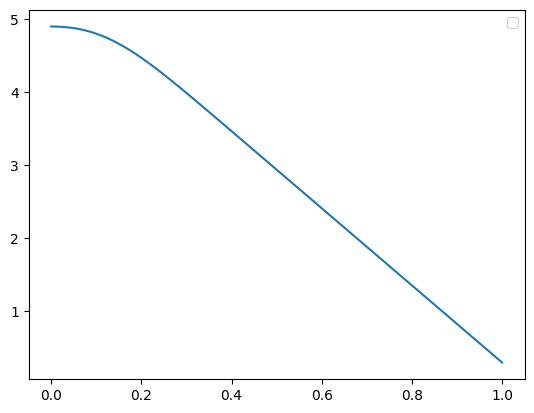

In [5]:
fig,ax = plt.subplots()
ax.plot(x,u[-1,:])
ax.legend()
plt.ioff()

In [6]:
import toml
import time

config_file = filename



cs = jnp.linspace(0.1,0.9,5)
D = 2.0
u0 = 0.3
G_comp = []
g_c_an = []
g_kappa_an = []
g_u0_an = []
fig2,ax2 = plt.subplots(2,3,sharex='col')
fig,ax=plt.subplots(1,4)
for c in list(cs):
    config = toml.load(config_file)
    config["DiffusionProblem"]["SourceCentre"] = float(c)
    config["DiffusionProblem"]["D"] = float(D)
    
    
    with open(config_file,"w") as f:
        s = toml.dump(config,f)
    MaNTA.run(filename)
    data = Dataset("./jax_adjoint.nc","r")
    p2 = data.groups["G_boundary"].variables["p0"][0]
    p1 = data.groups["G_p"].variables["D"][0]
    p0 = data.groups["G_p"].variables["SourceCentre"][0]
    G0 = data.variables["GFn"][0]
    data.close()
    ln, = ax2[0,0].plot(c,p0,'rx',linewidth=2.0)
    ax[0].plot(c,p0,'rx')
    ax[1].plot(c,p1,"rx")
    ax[2].plot(c,p2,"rx")
    ax[3].plot(c,G0,'rx')
   
ln.set_label(r"$\frac{dG}{dc}$ (adjoint)")
cs = jnp.linspace(np.min(cs),np.max(cs),50)
for c in cs:
    grad_c, grad_kappa, grad_u0 = gradp(c, D, u0)
    
    g_c_an.append(grad_c)
    g_kappa_an.append(grad_kappa)
    g_u0_an.append(grad_u0)
    G_comp.append(g(c,D, u0))

ax[0].plot(cs,g_c_an,'k')
ax2[0,0].plot(cs,g_c_an,'k',label=r"$\frac{dG}{dc}$ (analytic)",linewidth=2.0,zorder=-1)
ax[1].plot(cs,g_kappa_an,'k')
ax[2].plot(cs,g_u0_an,'k')

ax[3].plot(cs,G_comp,'k',label="analytic")

ycolor = 'b'

ax3 = ax2[1,0]
ax3.plot(cs,G_comp,label=r"$G(c)$",color=ycolor,linewidth=2.0)
# ax3.set_ylabel('G',color=ycolor)
# ax3.tick_params(axis='y', labelcolor=ycolor)

ax[0].set_title(r"$dG/dc$")
ax[1].set_title(r"$dG/d\kappa$")
ax[2].set_title(r"$dG/du_0$")
ax[3].set_title(r"$G = \int u^2/2 dx$")

ax[0].set_xlabel("c")
ax[1].set_xlabel("c")
ax[2].set_xlabel("c")
ax[3].set_xlabel("c")
ax2[1,0].set_xlabel("c")

ax[3].legend()

for a in ax:
    a.set_box_aspect(1)

fig.set_figwidth(15)






Number of parameters in adjoint problem:  5


INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 42 timesteps )
Writing output at 0.5 ( 47 timesteps )
Writing output at 0.75 ( 50 timesteps )
Writing output at 1 ( 53 timesteps )
Writing output at 1.25 ( 55 timesteps )
Writing output at 1.5 ( 57 timesteps )
Writing output at 1.75 ( 58 timesteps )
Writing output at 2 ( 60 timesteps )
Writing output at 2.25 ( 60 timesteps )
Writing output at 2.5 ( 61 timesteps )
Writing output at 2.75 ( 61 timesteps )
Writing output at 3 ( 62 timesteps )
Writing output at 3.25 ( 62 timesteps )
Writing output at 3.5 ( 62 timesteps )
Writing output at 3.75 ( 63 timesteps )
Writing output at 4 ( 63 timesteps )
Writing output at 4.25 ( 63 timesteps )
Writing output at 4.5 ( 63 timesteps )
Writing output at 4.75 ( 63 timesteps )
Writing output at 5 ( 64 timesteps )
Total Number of Timesteps             :64
Total Number of Residual Evaluations  :98
Total Number of Jacobian Computations :19
Computing adjoints
Done.
Number of parameter

INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 40 timesteps )
Writing output at 0.5 ( 45 timesteps )
Writing output at 0.75 ( 49 timesteps )
Writing output at 1 ( 51 timesteps )
Writing output at 1.25 ( 53 timesteps )
Writing output at 1.5 ( 56 timesteps )
Writing output at 1.75 ( 57 timesteps )
Writing output at 2 ( 58 timesteps )
Writing output at 2.25 ( 58 timesteps )
Writing output at 2.5 ( 59 timesteps )
Writing output at 2.75 ( 59 timesteps )
Writing output at 3 ( 60 timesteps )
Writing output at 3.25 ( 60 timesteps )
Writing output at 3.5 ( 60 timesteps )
Writing output at 3.75 ( 61 timesteps )
Writing output at 4 ( 61 timesteps )
Writing output at 4.25 ( 61 timesteps )
Writing output at 4.5 ( 61 timesteps )
Writing output at 4.75 ( 61 timesteps )
Writing output at 5 ( 61 timesteps )
Total Number of Timesteps             :61
Total Number of Residual Evaluations  :93
Total Number of Jacobian Computations :20
Computing adjoints
Done.
Number of parameter

INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 43 timesteps )
Writing output at 0.5 ( 48 timesteps )
Writing output at 0.75 ( 52 timesteps )
Writing output at 1 ( 55 timesteps )
Writing output at 1.25 ( 57 timesteps )
Writing output at 1.5 ( 59 timesteps )
Writing output at 1.75 ( 60 timesteps )
Writing output at 2 ( 61 timesteps )
Writing output at 2.25 ( 62 timesteps )
Writing output at 2.5 ( 63 timesteps )
Writing output at 2.75 ( 63 timesteps )
Writing output at 3 ( 63 timesteps )
Writing output at 3.25 ( 64 timesteps )
Writing output at 3.5 ( 64 timesteps )
Writing output at 3.75 ( 64 timesteps )
Writing output at 4 ( 64 timesteps )
Writing output at 4.25 ( 65 timesteps )
Writing output at 4.5 ( 65 timesteps )
Writing output at 4.75 ( 65 timesteps )
Writing output at 5 ( 65 timesteps )
Total Number of Timesteps             :65
Total Number of Residual Evaluations  :96
Total Number of Jacobian Computations :20
Computing adjoints
Done.
Number of parameter

INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 44 timesteps )
Writing output at 0.5 ( 50 timesteps )
Writing output at 0.75 ( 54 timesteps )
Writing output at 1 ( 57 timesteps )
Writing output at 1.25 ( 59 timesteps )
Writing output at 1.5 ( 60 timesteps )
Writing output at 1.75 ( 62 timesteps )
Writing output at 2 ( 64 timesteps )
Writing output at 2.25 ( 65 timesteps )
Writing output at 2.5 ( 65 timesteps )
Writing output at 2.75 ( 65 timesteps )
Writing output at 3 ( 66 timesteps )
Writing output at 3.25 ( 66 timesteps )
Writing output at 3.5 ( 67 timesteps )
Writing output at 3.75 ( 67 timesteps )
Writing output at 4 ( 67 timesteps )
Writing output at 4.25 ( 67 timesteps )
Writing output at 4.5 ( 68 timesteps )
Writing output at 4.75 ( 68 timesteps )
Writing output at 5 ( 68 timesteps )
Total Number of Timesteps             :68
Total Number of Residual Evaluations  :102
Total Number of Jacobian Computations :20
Computing adjoints
Done.
Number of paramete

INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 48 timesteps )
Writing output at 0.5 ( 52 timesteps )
Writing output at 0.75 ( 55 timesteps )
Writing output at 1 ( 58 timesteps )
Writing output at 1.25 ( 60 timesteps )
Writing output at 1.5 ( 61 timesteps )
Writing output at 1.75 ( 62 timesteps )
Writing output at 2 ( 63 timesteps )
Writing output at 2.25 ( 63 timesteps )
Writing output at 2.5 ( 64 timesteps )
Writing output at 2.75 ( 64 timesteps )
Writing output at 3 ( 64 timesteps )
Writing output at 3.25 ( 65 timesteps )
Writing output at 3.5 ( 65 timesteps )
Writing output at 3.75 ( 65 timesteps )
Writing output at 4 ( 65 timesteps )
Writing output at 4.25 ( 66 timesteps )
Writing output at 4.5 ( 66 timesteps )
Writing output at 4.75 ( 66 timesteps )
Writing output at 5 ( 66 timesteps )
Total Number of Timesteps             :66
Total Number of Residual Evaluations  :101
Total Number of Jacobian Computations :21
Computing adjoints
Done.


In [7]:
c = 0.3
Ds = jnp.linspace(2.0,10.0,5)
u0 = 0.3
G_comp = []
g_c_an = []
g_kappa_an = []
g_u0_an = []
fig,ax=plt.subplots(1,4)
for D in list(Ds):
    config = toml.load(config_file)
    config["DiffusionProblem"]["SourceCentre"] = float(c)
    config["DiffusionProblem"]["D"] = float(D)
    
    with open(config_file,"w") as f:
        s = toml.dump(config,f)
    MaNTA.run(filename)
    data = Dataset("./jax_adjoint.nc","r")
    p2 = np.array(data.groups["G_boundary"].variables["p0"])
    p1 = np.array(data.groups["G_p"].variables["D"])
    p0 = np.array(data.groups["G_p"].variables["SourceCentre"])
    G0 = np.array(data.variables["GFn"])
    data.close()

    ax[0].plot(D,p0,'rx')
    ax[1].plot(D,p1,"rx")
    ln, = ax2[0,1].plot(D,p1,"rx",linewidth=2.0)
    ax[2].plot(D,p2,"rx")
    ax[3].plot(D,G0,'rx')

ln.set_label(r"$\frac{dG}{dD}$ (adjoint)")

Ds = jnp.linspace(2.0,10.0,50)
for D in Ds:
    grad_c, grad_kappa, grad_u0 = gradp(c, D, u0)
    
    g_c_an.append(grad_c)
    g_kappa_an.append(grad_kappa)
    g_u0_an.append(grad_u0)
    G_comp.append(g(c,D,u0))

ax[0].plot(Ds,g_c_an,'k')
ax[1].plot(Ds,g_kappa_an,'k')
ax2[0,1].plot(Ds,g_kappa_an,'k',label=r"$\frac{dG}{dD}$ (analytic)",linewidth=2.0,zorder=-1)
ax[2].plot(Ds,g_u0_an,'k')
ax[3].plot(Ds,G_comp,'k')

ax3 = ax2[1,1]
ax3.plot(Ds,G_comp,label=r"$G(D)$",color=ycolor,linewidth=2.0)
# ax3.set_ylabel('G',color=ycolor)
# ax3.tick_params(axis='y', labelcolor=ycolor)

ax[0].set_title(r"$dG/dc$")
ax[1].set_title(r"$dG/d\kappa$")
ax[2].set_title(r"$dG/du_0$")
ax[3].set_title(r"$G = \int u^2/2 dx$")

ax[0].set_xlabel("D")
ax[1].set_xlabel("D")
ax[2].set_xlabel("D")
ax[3].set_xlabel("D")
ax2[1,1].set_xlabel("D")

ax[3].legend()

for a in ax:
    a.set_box_aspect(1)

fig.set_figwidth(15)



Number of parameters in adjoint problem:  5


INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 40 timesteps )
Writing output at 0.5 ( 45 timesteps )
Writing output at 0.75 ( 49 timesteps )
Writing output at 1 ( 51 timesteps )
Writing output at 1.25 ( 53 timesteps )
Writing output at 1.5 ( 56 timesteps )
Writing output at 1.75 ( 57 timesteps )
Writing output at 2 ( 58 timesteps )
Writing output at 2.25 ( 58 timesteps )
Writing output at 2.5 ( 59 timesteps )
Writing output at 2.75 ( 59 timesteps )
Writing output at 3 ( 60 timesteps )
Writing output at 3.25 ( 60 timesteps )
Writing output at 3.5 ( 60 timesteps )
Writing output at 3.75 ( 61 timesteps )
Writing output at 4 ( 61 timesteps )
Writing output at 4.25 ( 61 timesteps )
Writing output at 4.5 ( 61 timesteps )
Writing output at 4.75 ( 61 timesteps )
Writing output at 5 ( 61 timesteps )
Total Number of Timesteps             :61
Total Number of Residual Evaluations  :93
Total Number of Jacobian Computations :20
Computing adjoints
Done.
Number of parameter

/tmp/ipykernel_63023/2299206510.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p2 = np.array(data.groups["G_boundary"].variables["p0"])
/tmp/ipykernel_63023/2299206510.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  p1 = np.array(data.groups["G_p"].variables["D"])
/tmp/ipykernel_63023/2299206510.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argum

Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 43 timesteps )
Writing output at 0.5 ( 49 timesteps )
Writing output at 0.75 ( 53 timesteps )
Writing output at 1 ( 55 timesteps )
Writing output at 1.25 ( 56 timesteps )
Writing output at 1.5 ( 57 timesteps )
Writing output at 1.75 ( 58 timesteps )
Writing output at 2 ( 58 timesteps )
Writing output at 2.25 ( 58 timesteps )
Writing output at 2.5 ( 59 timesteps )
Writing output at 2.75 ( 59 timesteps )
Writing output at 3 ( 59 timesteps )
Writing output at 3.25 ( 59 timesteps )
Writing output at 3.5 ( 59 timesteps )
Writing output at 3.75 ( 60 timesteps )
Writing output at 4 ( 60 timesteps )
Writing output at 4.25 ( 60 timesteps )
Writing output at 4.5 ( 60 timesteps )
Writing output at 4.75 ( 60 timesteps )
Writing output at 5 ( 60 timesteps )
Total Number of Timesteps             :60
Total Number of Residual Evaluations  :94
Total Number of Jacobian Computations :20
Computing adjoints
Done.
Number of parameter

INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 47 timesteps )
Writing output at 0.5 ( 53 timesteps )
Writing output at 0.75 ( 56 timesteps )
Writing output at 1 ( 57 timesteps )
Writing output at 1.25 ( 58 timesteps )
Writing output at 1.5 ( 58 timesteps )
Writing output at 1.75 ( 58 timesteps )
Writing output at 2 ( 59 timesteps )
Writing output at 2.25 ( 59 timesteps )
Writing output at 2.5 ( 59 timesteps )
Writing output at 2.75 ( 59 timesteps )
Writing output at 3 ( 59 timesteps )
Writing output at 3.25 ( 60 timesteps )
Writing output at 3.5 ( 60 timesteps )
Writing output at 3.75 ( 60 timesteps )
Writing output at 4 ( 60 timesteps )
Writing output at 4.25 ( 60 timesteps )
Writing output at 4.5 ( 60 timesteps )
Writing output at 4.75 ( 60 timesteps )
Writing output at 5 ( 60 timesteps )
Total Number of Timesteps             :60
Total Number of Residual Evaluations  :91
Total Number of Jacobian Computations :21
Computing adjoints
Done.
Number of parameter

INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 51 timesteps )
Writing output at 0.5 ( 57 timesteps )
Writing output at 0.75 ( 60 timesteps )
Writing output at 1 ( 61 timesteps )
Writing output at 1.25 ( 61 timesteps )
Writing output at 1.5 ( 62 timesteps )
Writing output at 1.75 ( 62 timesteps )
Writing output at 2 ( 63 timesteps )
Writing output at 2.25 ( 63 timesteps )
Writing output at 2.5 ( 63 timesteps )
Writing output at 2.75 ( 63 timesteps )
Writing output at 3 ( 63 timesteps )
Writing output at 3.25 ( 63 timesteps )
Writing output at 3.5 ( 64 timesteps )
Writing output at 3.75 ( 64 timesteps )
Writing output at 4 ( 64 timesteps )
Writing output at 4.25 ( 64 timesteps )
Writing output at 4.5 ( 64 timesteps )
Writing output at 4.75 ( 64 timesteps )
Writing output at 5 ( 64 timesteps )
Total Number of Timesteps             :64
Total Number of Residual Evaluations  :96
Total Number of Jacobian Computations :20
Computing adjoints
Done.
Number of parameter

INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131


Number of Residual Evaluations due to IDACalcIC 2
Writing output at 0.25 ( 52 timesteps )
Writing output at 0.5 ( 57 timesteps )
Writing output at 0.75 ( 59 timesteps )
Writing output at 1 ( 59 timesteps )
Writing output at 1.25 ( 60 timesteps )
Writing output at 1.5 ( 60 timesteps )
Writing output at 1.75 ( 61 timesteps )
Writing output at 2 ( 61 timesteps )
Writing output at 2.25 ( 61 timesteps )
Writing output at 2.5 ( 61 timesteps )
Writing output at 2.75 ( 61 timesteps )
Writing output at 3 ( 61 timesteps )
Writing output at 3.25 ( 62 timesteps )
Writing output at 3.5 ( 62 timesteps )
Writing output at 3.75 ( 62 timesteps )
Writing output at 4 ( 62 timesteps )
Writing output at 4.25 ( 62 timesteps )
Writing output at 4.5 ( 62 timesteps )
Writing output at 4.75 ( 62 timesteps )
Writing output at 5 ( 62 timesteps )
Total Number of Timesteps             :62
Total Number of Residual Evaluations  :94
Total Number of Jacobian Computations :20
Computing adjoints
Done.


/tmp/ipykernel_63023/2299206510.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[3].legend()


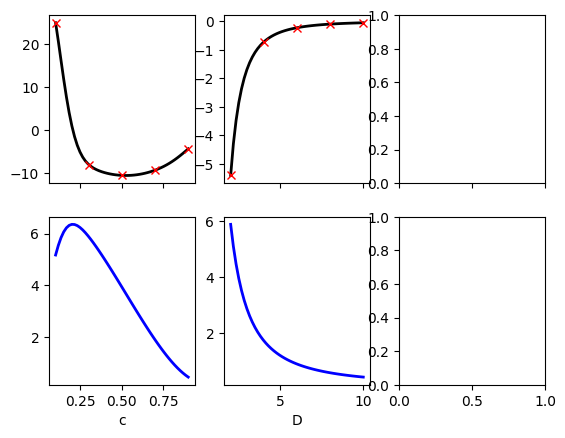

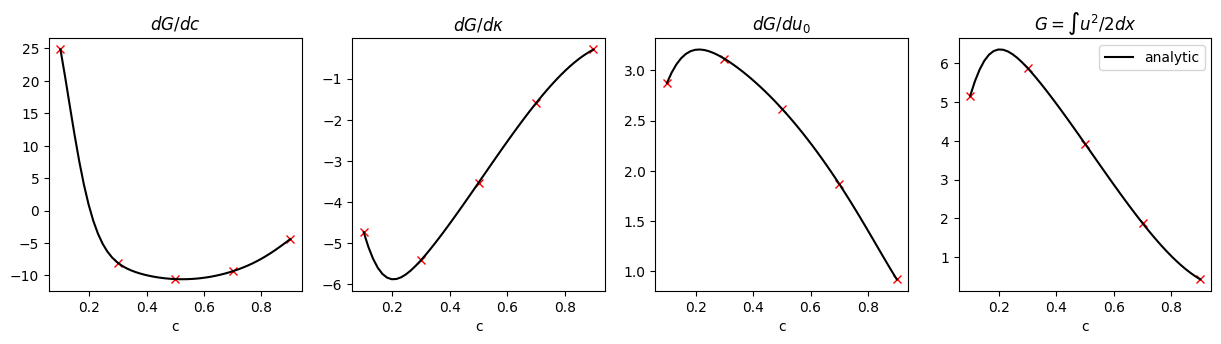

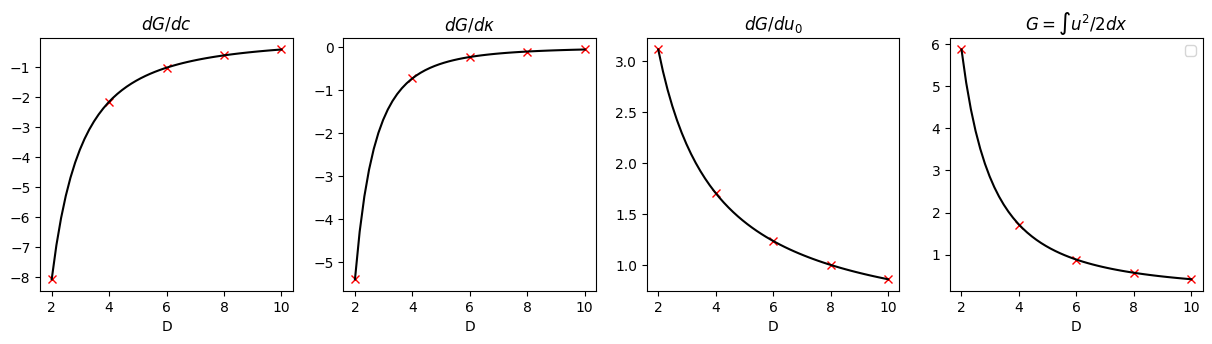

In [8]:
plt.show()